# Ejemplo KNN

Este es un ejemplo de la realización de una experimentación con KNN.

Las prácticas de KNN deberían tener una estructura similar a la de este Notebook.

## Importamos las librerías a utilizar

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import matplotlib

In [3]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Definimos variables globales

In [4]:
DATASET_NAME = 'data/toyExample.data'
DATASET_DELIMITER = ','

# NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados
SEED_VALUE = 7 

## Leemos el fichero de datos

In [5]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=0,
                      header=None,
                      names = ["X0", "X1", "Y"])
dataset

,X0,X1,Y
0,-1,5,0
1,-2,3,0
2,-1,0,1
3,-1,-2,1
4,-3,-4,0
5,-2,-1,0
6,1,5,1
7,2,3,1
8,1,0,1
9,1,3,1


El fichero contiene 3 variables y 16 observaciones distintas. Las variables predictoras son `X0` y `X1`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

## Visualizamos los datos

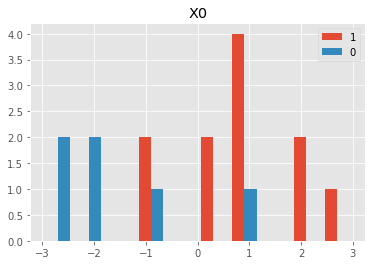

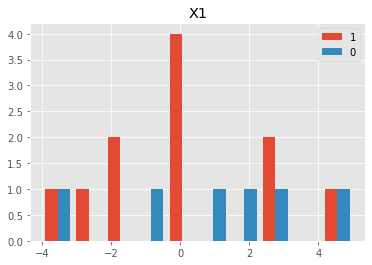

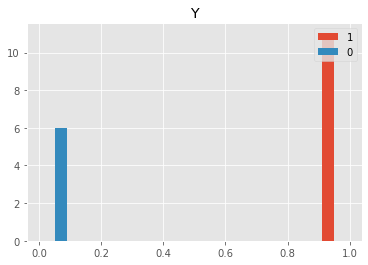

In [6]:
for column in dataset:  # Visualizamos la distribución de variables por clases
    plt.title(column)
    plt.hist([dataset[dataset['Y'] == 1][column], dataset[dataset['Y'] == 0][column]], label=['1', '0'])
    plt.legend(loc='upper right')
    plt.show()

También podemos visualizar los datos y sus clases por pares de atributos:

<AxesSubplot:xlabel='X0', ylabel='X1'>

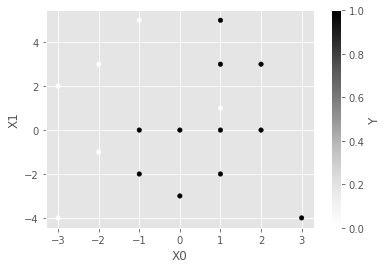

In [7]:
fig, ax = plt.subplots()
dataset.plot.scatter('X0', 'X1', c='Y', ax=ax)

# Se puede representar en una línea sola
# dataset.plot.scatter('X0', 'X1', c='Y')

## División de los datos en entrenamiento (80%) y test (20%):

<span style="color:red">**MUY IMPORTANTE:**</span> Vamos a establecer una semilla con un valor predefinido inmediatamente antes de ejecutar cualquier operación con un componente aleatorio. Así aseguramos que nuestros resultados sean repetibles.

Esto es, vamos a poner `np.random.seed(SEED_VALUE)` antes de:
 - `fit()`
 - `predict()`
 
En aquellas funciones que lo admitan, sustituiremos el comando np.random.seed(SEED_VALUE) por el argumento `random_state=SEED_VALUE`. Por ejemplo, para la división de datos entre entrenamiento y test con `train_test_split`.

In [8]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE)
dataset_test

,X0,X1,Y
13,0,0,1
11,3,-4,1
16,-3,2,0
8,1,0,1


## Gestión de valores faltantes

En este caso, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera.

In [9]:
imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
imp = imp.fit(dataset_train)  # La media la calculamos SÓLO a partir del conjunto de train

# Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
dataset_train_prep = imp.transform(dataset_train)
dataset_test_prep = imp.transform(dataset_test)

dataset_test_prep

array([[ 0.,  0.,  1.],
       [ 3., -4.,  1.],
       [-3.,  2.,  0.],
       [ 1.,  0.,  1.]])

`SimpleImputer` ha convertido nuestros valores a un array NumPy, por lo que sería bueno que los volviéramos a convertir en formato dataframe.

In [10]:
dataset_train = pd.DataFrame(dataset_train_prep,
                             columns=dataset_train.columns,
                             index=dataset_train.index)
dataset_test = pd.DataFrame(dataset_test_prep,
                            columns=dataset_test.columns,
                            index=dataset_test.index)

dataset_train

,X0,X1,Y
5,-2.0,-1.0,0.0
2,-1.0,0.0,1.0
1,-2.0,3.0,0.0
0,-1.0,5.0,0.0
14,1.0,1.0,0.0
10,1.0,-2.0,1.0
7,2.0,3.0,1.0
12,2.0,0.0,1.0
3,-1.0,-2.0,1.0
6,1.0,5.0,1.0


## Separación de variables predictoras y dependientes

In [11]:
dataset_train_X = dataset_train.loc[:, 'X0':'X1'].astype(float)
dataset_train_Y = dataset_train.loc[:, 'Y']

dataset_test_X = dataset_test.loc[:, 'X0':'X1'].astype(float)
dataset_test_Y = dataset_test.loc[:, 'Y']

dataset_test_X

,X0,X1
13,0.0,0.0
11,3.0,-4.0
16,-3.0,2.0
8,1.0,0.0


## Estandarización de los datos

Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test.

Además, como es un problema de clasificación, **NO** estandarizaremos la variable dependiente.

In [12]:
scaler = StandardScaler()

scaler.fit(dataset_train_X)

dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled

array([[ 0.09853293, -0.21442251],
       [ 2.01992502, -1.6081688 ],
       [-1.82285916,  0.48245064],
       [ 0.73899696, -0.21442251]])

Estos son los valores con los que se ha estandarizado.

In [13]:
print("mean [X0, X1]: {}  |  std [X0, X1]: {}".format(scaler.mean_, scaler.scale_))

mean [X0, X1]: [-0.15384615  0.61538462]  |  std [X0, X1]: [1.56136793 2.86996279]


## Empezamos con la experimentación de KNN

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor.

## Definimos un rango de hiperparámetros para realizar las pruebas

In [14]:
hyperparameters = {'n_neighbors': range(1, 6, 1), 'weights': ['uniform', 'distance']}

## Comenzamos las pruebas con 5-CV

In [15]:
k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       return_train_score=True)

# Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)

# En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 6),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

## Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [16]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]


,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,uniform,1,0.766667,0.200000,2
1,distance,1,0.766667,0.200000,2
2,uniform,2,0.766667,0.290593,2
3,distance,2,0.766667,0.200000,2
4,uniform,3,0.733333,0.226078,6
5,distance,3,0.733333,0.226078,6
6,uniform,4,0.833333,0.210819,1
7,distance,4,0.733333,0.226078,6
8,uniform,5,0.666667,0.182574,9
9,distance,5,0.600000,0.081650,10


Los mejores hiperparámetros en validación serían los siguientes (aunque no siempre conviene quedarse con los mejores):

In [17]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]


,param_weights,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
6,uniform,4,0.833333,0.210819,1


## Gráfica de entrenamiento

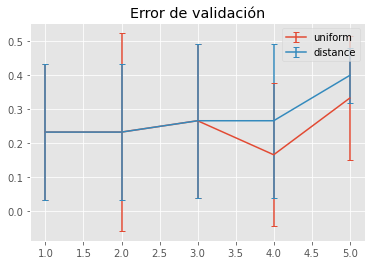

In [18]:
cv_results_uniform = cv_results.loc[cv_results['param_weights'] == "uniform"]
cv_results_distance = cv_results.loc[cv_results['param_weights'] == "distance"]

plt.title("Error de validación")
plt.errorbar(cv_results_uniform['param_n_neighbors'], 1 - cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='uniform', capsize=3)  # 1 - [] para imprimir el error
plt.errorbar(cv_results_distance['param_n_neighbors'], 1 - cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='distance', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()


## Creación de un modelo con los mejores hiperparámetros

"Entrenamos" un modelo con el menor error de validación cruzada (`n_neighbors = 4`, `weights = 'uniform'`) y con todo el conjunto de entrenamiento.

In [19]:
model = KNeighborsClassifier(n_neighbors = 4, weights = 'uniform', algorithm='brute')

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
model.fit(dataset_train_X_scaled, dataset_train_Y)

KNeighborsClassifier(algorithm='brute', n_neighbors=4)

## Evaluación del modelo en el conjunto de test

In [20]:
np.random.seed(SEED_VALUE)
Z = model.predict(dataset_test_X_scaled)

In [21]:
accuracy_test = accuracy_score(dataset_test_Y, Z)
print("Accuracy en test: {}  |  Error en test: {}".format(accuracy_test, 1-accuracy_test))

Accuracy en test: 1.0  |  Error en test: 0.0


C:\Users\Andres\AppData\Local\Temp/ipykernel_13380/458563234.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, dense_Z, cmap=cmap_light)


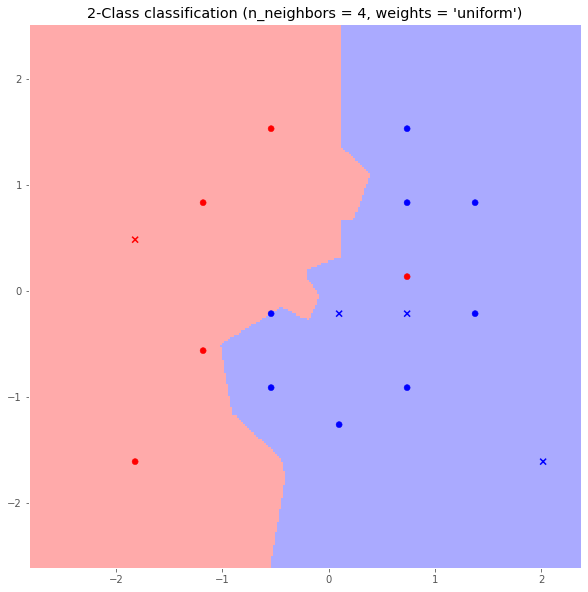

In [22]:
# Todo esto es simplemente para crear una gráfica. No es necesario prestarle demasiada atención

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = matplotlib.colors.ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = matplotlib.colors.ListedColormap(['#FF0000', '#0000FF'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min = dataset_train_X_scaled[:, 0].min() - 1  # Le sumo y resto 1 para poder ir un poco más allá de los ejemplos y verlo mejor
x_max = dataset_train_X_scaled[:, 0].max() + 1
y_min = dataset_train_X_scaled[:, 1].min() - 1
y_max = dataset_train_X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

np.random.seed(SEED_VALUE)
dense_Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
dense_Z = dense_Z.reshape(xx.shape)
plt.figure(figsize=[10, 10])
plt.pcolormesh(xx, yy, dense_Z, cmap=cmap_light)

# Plot the training and test points
plt.scatter(dataset_train_X_scaled[:, 0], 
            dataset_train_X_scaled[:, 1], 
            c=dataset_train_Y, cmap=cmap_bold, marker="o")
plt.scatter(dataset_test_X_scaled[:, 0], 
            dataset_test_X_scaled[:, 1], 
            c=dataset_test_Y, cmap=cmap_bold, marker="x")
plt.axis('scaled')  # Para que los ejes estén en la misma escala
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (n_neighbors = 4, weights = 'uniform')")

plt.show()

## Verificación de nuestros hiperparámetros

Esto no se haría **JAMÁS** en una situación real.
Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales".

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [23]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       return_train_score=True,
                       verbose=1,
                       n_jobs=-1)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV.fit(dataset_all_X_scaled, dataset_all_Y)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0])),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 6),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [24]:
test_results = pd.DataFrame(modelCV.cv_results_)
test_results.loc[:, ['param_weights', 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

,param_weights,param_n_neighbors,mean_test_score,rank_test_score
0,uniform,1,0.75,7
1,distance,1,0.75,7
2,uniform,2,0.50,10
3,distance,2,0.75,7
4,uniform,3,1.00,1
5,distance,3,1.00,1
6,uniform,4,1.00,1
7,distance,4,1.00,1
8,uniform,5,1.00,1
9,distance,5,1.00,1


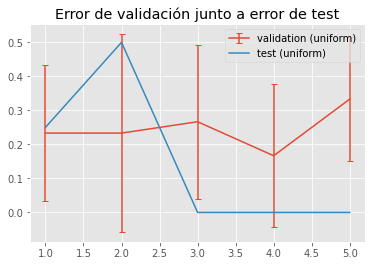

In [31]:
plt.title("Error de validación junto a error de test")

cv_results_uniform = cv_results[cv_results['param_weights'] == 'uniform']
cv_results_distance = cv_results[cv_results['param_weights'] == 'distance']

test_results_uniform = test_results[test_results['param_weights'] == 'uniform']  # Lo vamos a limitar a `weights = 'uniform'`
test_results_distance = test_results[test_results['param_weights'] == 'distance']  # Lo vamos a limitar a `weights = 'distance'`

plt.errorbar(cv_results_uniform['param_n_neighbors'], 1 - cv_results_uniform['mean_test_score'], cv_results_uniform['std_test_score'], label='validation (uniform)', capsize=3)  # 1 - [] para imprimir el error
# plt.errorbar(cv_results_distance['param_n_neighbors'], 1 - cv_results_distance['mean_test_score'], cv_results_distance['std_test_score'], label='validation (distance)', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(test_results_uniform['param_n_neighbors'], 1 - test_results_uniform['mean_test_score'], label='test (uniform)', capsize=3)  # 1 - [] para imprimir el error
# plt.errorbar(test_results_distance['param_n_neighbors'], 1 - test_results_distance['mean_test_score'], label='test (distance)', capsize=3)  # 1 - [] para imprimir el error

plt.legend(loc='upper right')
plt.show()

Parece que el menor error de test se obtendría con los mismos hiperparámetros (pero también con otros).

## Almacenamiento y restauración del modelo

Una vez hemos entrenado un modelo, podemos guardarlo para su posterior uso mediante `joblib`. Así no tendremos que reentrenarlo si cerramos la sesión con el Jupyter Notebook.

In [32]:
joblib.dump(model, 'my_knn_model.joblib')

['my_knn_model.joblib']

Una vez hemos guardado el modelo, podemos cargarlo y utilizarlo para predecir

In [33]:
restored_model = joblib.load('my_knn_model.joblib') 

<ipython-input-34-0b8bc0c3fcd7>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, dense_Z, cmap=cmap_light)


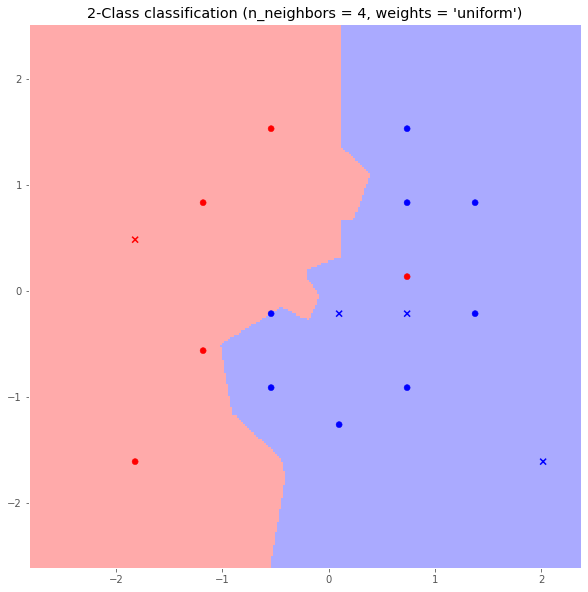

In [34]:
h = 0.02  # step size in the mesh

# Create color maps
cmap_light = matplotlib.colors.ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = matplotlib.colors.ListedColormap(['#FF0000', '#0000FF'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min = dataset_train_X_scaled[:, 0].min() - 1  # Le sumo y resto 1 para poder ir un poco más allá de los ejemplos y verlo mejor
x_max = dataset_train_X_scaled[:, 0].max() + 1
y_min = dataset_train_X_scaled[:, 1].min() - 1
y_max = dataset_train_X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

np.random.seed(SEED_VALUE)
dense_Z = restored_model.predict(np.c_[xx.ravel(), yy.ravel()])  # *** Nótese que usamos restored_model ***

# Put the result into a color plot
dense_Z = dense_Z.reshape(xx.shape)
plt.figure(figsize=[10, 10])
plt.pcolormesh(xx, yy, dense_Z, cmap=cmap_light)

# Plot the training and test points
# Plot the training and test points
plt.scatter(dataset_train_X_scaled[:, 0], 
            dataset_train_X_scaled[:, 1], 
            c=dataset_train_Y, cmap=cmap_bold, marker="o")
plt.scatter(dataset_test_X_scaled[:, 0], 
            dataset_test_X_scaled[:, 1], 
            c=dataset_test_Y, cmap=cmap_bold, marker="x")
plt.axis('scaled')  # Para que los ejes estén en la misma escala
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (n_neighbors = 4, weights = 'uniform')")

plt.show()